### Small scaled Dataset for implementation

In [ ]:
import pandas as pd
import zipfile
import requests
from io import BytesIO

# URL for the MovieLens Latest Small dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'

# Send a HTTP request to the server and get the content
response = requests.get(url)
content = BytesIO(response.content)

# Extract the file from the zip
with zipfile.ZipFile(content) as z:
    z.extractall('movielens')  # Extracts to folder 'movielens'

# Load the movie data
movies_path = 'movielens/ml-latest-small/movies.csv'
movie_data = pd.read_csv(movies_path)

# Display the first few entries
print(movie_data.head())


   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


### Vectorizing the Genres


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Initialize a TfidfVectorizer to handle the pipe '|' as a token separator
tfidf = TfidfVectorizer(stop_words='english', token_pattern='(?u)\\b[^|]+\\b')

# Fit and transform the 'genres' into a TF-IDF matrix
tfidf_matrix = tfidf.fit_transform(movie_data['genres'])

# Calculate the cosine similarity matrix based on the TF-IDF vectors
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Display the shape of the cosine similarity matrix
print(cosine_sim.shape)


(9742, 9742)


### Build the Recommendation Function

In [ ]:
def recommend_movies(title, movie_data, cosine_sim, top_n=10):
    # Find the movie index
    idx = movie_data.index[movie_data['title'] == title].tolist()[0]

    # Get the pairwise similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the top-n most similar movies
    sim_scores = sim_scores[1:top_n+1]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top-n most similar movies
    return movie_data['title'].iloc[movie_indices]

# Example: Recommend movies similar to a given title
recommendations = recommend_movies('Toy Story (1995)', movie_data, cosine_sim)
print(recommendations)


1706                                          Antz (1998)
2355                                   Toy Story 2 (1999)
2809       Adventures of Rocky and Bullwinkle, The (2000)
3000                     Emperor's New Groove, The (2000)
3568                                Monsters, Inc. (2001)
6194                                     Wild, The (2006)
6486                               Shrek the Third (2007)
6948                       Tale of Despereaux, The (2008)
7760    Asterix and the Vikings (Astérix et les Viking...
8219                                         Turbo (2013)
Name: title, dtype: object


## Visual Representation of Results

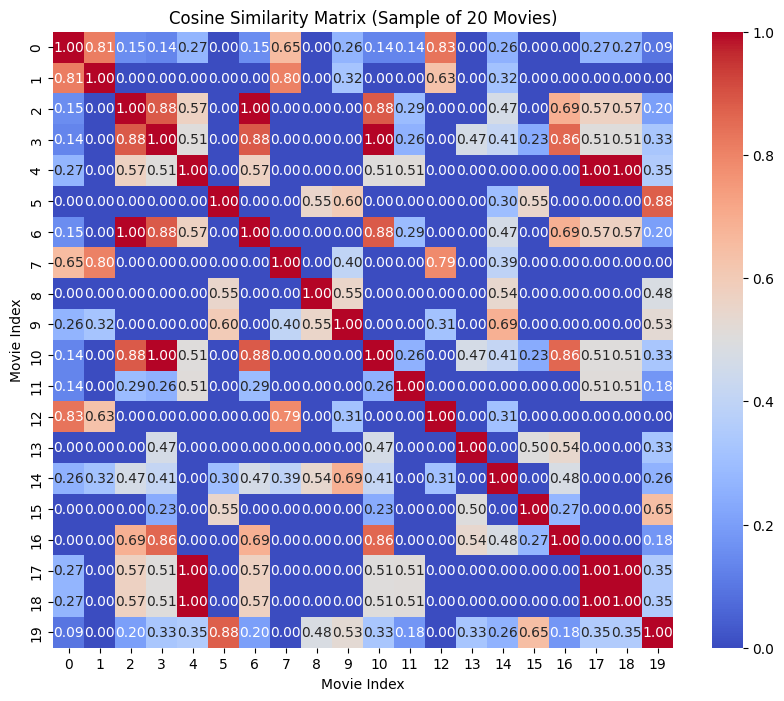

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot a heatmap of the cosine similarity matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim[:20, :20], annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Cosine Similarity Matrix (Sample of 20 Movies)')
plt.xlabel('Movie Index')
plt.ylabel('Movie Index')
plt.show()


<ipython-input-18-7179afb448c7>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=scores, y=recommended_movies, palette='viridis')


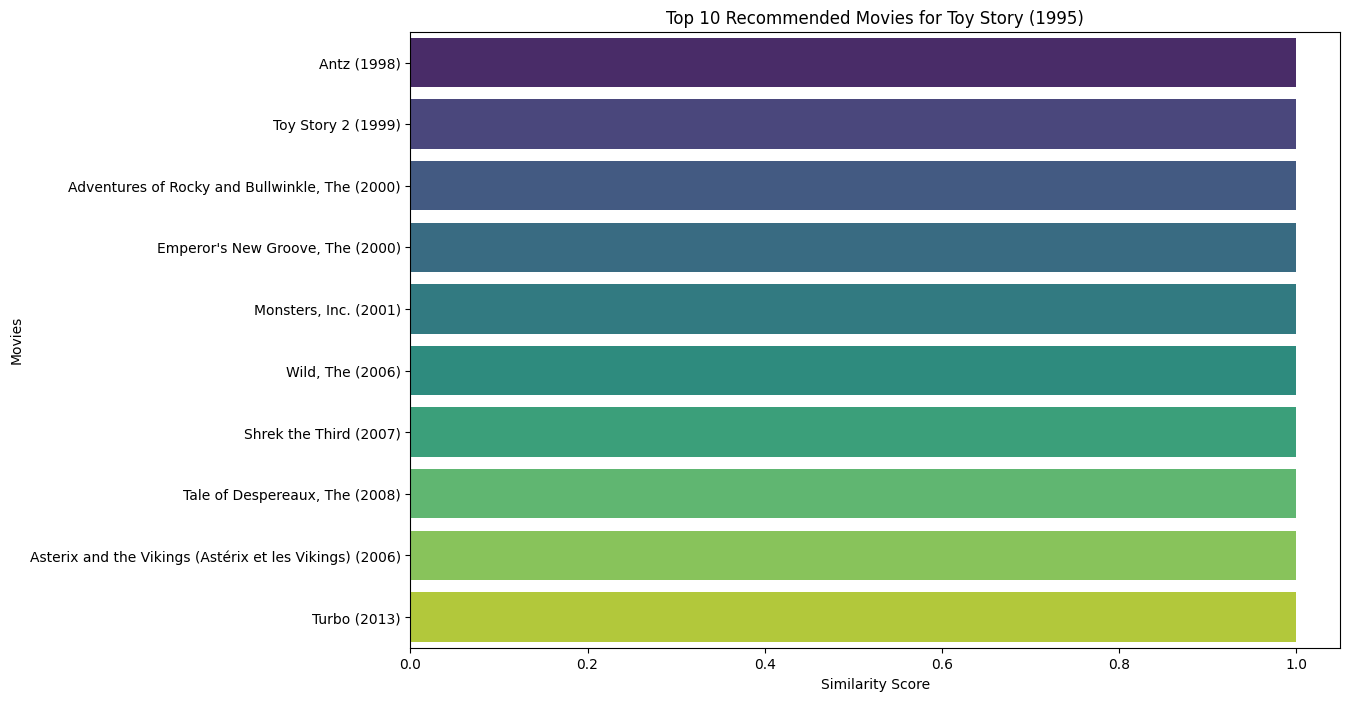

In [ ]:
def plot_recommendations(title, movie_data, cosine_sim):
    recommended_movies = recommend_movies(title, movie_data, cosine_sim, top_n=10)
    indices = [movie_data.index[movie_data['title'] == rec].tolist()[0] for rec in recommended_movies]
    scores = [cosine_sim[movie_data.index[movie_data['title'] == title].tolist()[0], idx] for idx in indices]

    plt.figure(figsize=(12, 8))
    sns.barplot(x=scores, y=recommended_movies, palette='viridis')
    plt.title(f'Top 10 Recommended Movies for {title}')
    plt.xlabel('Similarity Score')
    plt.ylabel('Movies')
    plt.show()

# Example: Visualize recommendations for 'Toy Story (1995)'
plot_recommendations('Toy Story (1995)', movie_data, cosine_sim)

## Code for normal Content Based RS

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import requests
import zipfile
import io

# Download the MovieLens dataset
url = 'http://files.grouplens.org/datasets/movielens/ml-latest-small.zip'
response = requests.get(url)
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    z.extractall()

# Load the dataset
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

# Preprocess the data
# Merge movies and ratings data
data = pd.merge(ratings, movies, on='movieId')

# Aggregate genres and ratings for each movie
movie_data = data.groupby('movieId').agg({
    'rating': 'mean',
    'genres': 'first'
}).reset_index()

# Calculate TF-IDF vectors for genres
tfidf = TfidfVectorizer(token_pattern='[a-zA-Z0-9\-]+')
tfidf_matrix = tfidf.fit_transform(movie_data['genres'])

# Calculate cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Function to get recommendations
def get_recommendations(title, cosine_sim=cosine_sim):
    idx = movie_data[movie_data['genres'].str.contains(title)].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:11]
    movie_indices = [i[0] for i in sim_scores]
    return movie_data.iloc[movie_indices]

# Get recommendations for a sample movie
recommendations = get_recommendations('Comedy')
print(recommendations[['movieId', 'rating', 'genres']])


      movieId    rating                                       genres
1705     2294  3.244444  Adventure|Animation|Children|Comedy|Fantasy
2353     3114  3.860825  Adventure|Animation|Children|Comedy|Fantasy
2805     3754  2.222222  Adventure|Animation|Children|Comedy|Fantasy
2996     4016  3.716216  Adventure|Animation|Children|Comedy|Fantasy
3563     4886  3.871212  Adventure|Animation|Children|Comedy|Fantasy
6177    45074  2.500000  Adventure|Animation|Children|Comedy|Fantasy
6469    53121  3.023810  Adventure|Animation|Children|Comedy|Fantasy
6931    65577  3.000000  Adventure|Animation|Children|Comedy|Fantasy
7742    91355  5.000000  Adventure|Animation|Children|Comedy|Fantasy
8201   103755  2.500000  Adventure|Animation|Children|Comedy|Fantasy
